In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
from sklearn.model_selection import train_test_split
pio.renderers.default = "notebook"
df = pd.read_csv("creditcard.csv")

## Explor Dataset

In [2]:
## Explore the data
print(df.shape)
print(df.head())
print(df.describe())
print(df.info())

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

<Axes: ylabel='Class'>

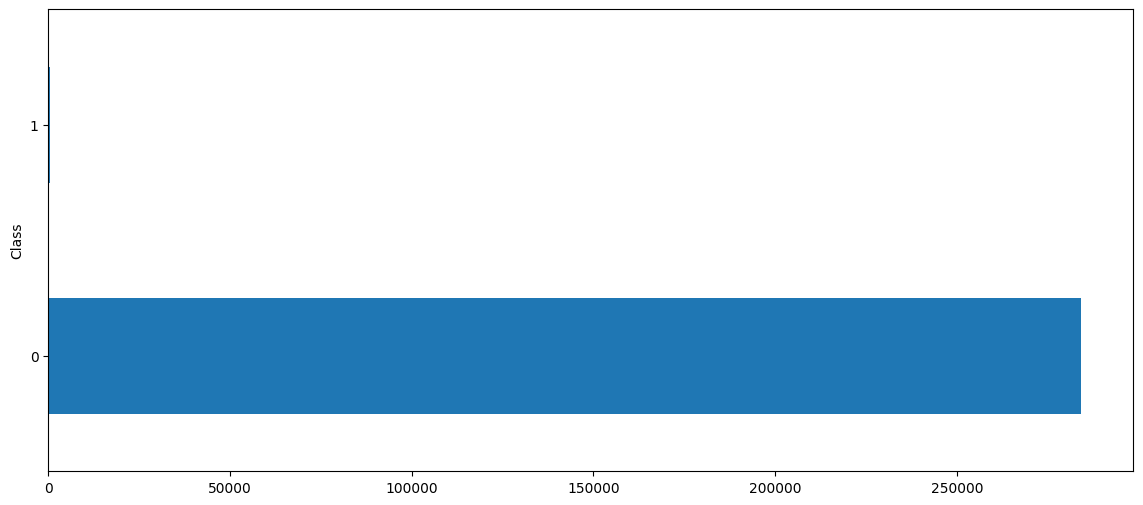

In [3]:
plt.figure(figsize=(14, 6))
df.groupby('Class').size().plot(kind='barh')

## Create Transformer ##
    Scaler : custom min/max scaler
## import RandomUnderSampler, RandomOverSampler, SMOTE for imbalance class datasets

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        
    def fit(self, X, y=None):
        if self.features is None:
            self.features = X.columns.tolist()
        self.min_ = {}
        self.max_ = {}
        for feature in self.features:
            self.min_[feature] = X[feature].min()
            self.max_[feature] = X[feature].max()
        return self

    def transform(self, X):
        for feature in self.features:
            X[feature] = (X[feature] - self.min_[feature]) / (self.max_[feature] - self.min_[feature])
        return X
## undersampling
from imblearn.under_sampling import RandomUnderSampler
## oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE


## Feature Engineering Model Base with Shap

In [5]:
## train-test split
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
## pipeline
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
## pipeline random over sampling
pipeline_random = Pipeline([
    ("scaler", Scaler()),
    ('oversampling', RandomOverSampler(random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
## pipeline smote
pipeline_smote = Pipeline([
    ("scaler", Scaler()),
    ('oversampling', SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
pipelines = {
    "Random Under Sampling": pipeline_random,
    "SMOTE": pipeline_smote
}
for name, pipeline in pipelines.items():
    print(f"Training pipeline: {name}")
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    # Evaluate the model
    from sklearn.metrics import classification_report, confusion_matrix
    y_pred = pipeline.predict(X_test)
    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Training pipeline: Random Under Sampling
Results for Random Under Sampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56860     4]
 [   23    75]]


Training pipeline: SMOTE
Results for SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56850    14]
 [   16    82]]




In [7]:
## feature importance
import shap
selected_pipeline = pipelines["SMOTE"]
explainer = shap.TreeExplainer(selected_pipeline.named_steps["classifier"])

class1_index = y_test[y_test == 1].index
shap_values = explainer.shap_values(X_test.loc[class1_index])

/Users/tale/Documents/ml/credit-card-fraud-detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



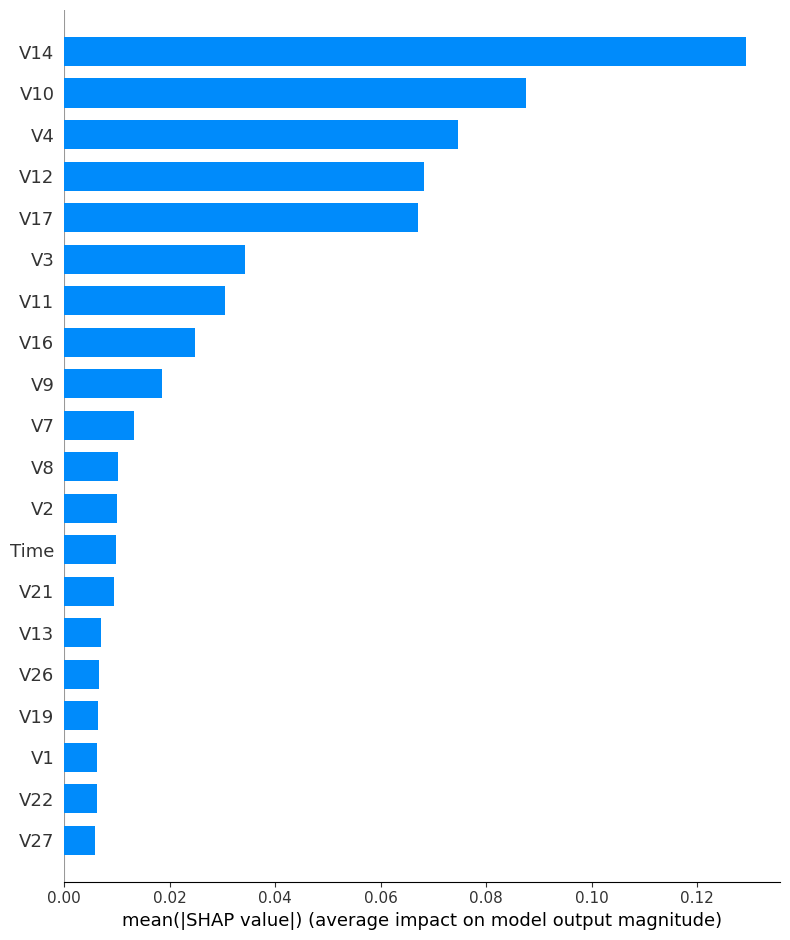

In [8]:
## feature importance plot
shap.summary_plot(shap_values[:, :, 1], X_test.loc[class1_index], plot_type="bar")

In [8]:
feature_importance = pd.Series(shap_values[:, :, 1].mean(axis=0), index=X_test.columns)
feature_importance.sort_values(ascending=False, inplace=True)
k = 10
selected_features = feature_importance.head(k).index.tolist()
print(f"Top {k} features based on SHAP values:")
print(selected_features)

Top 10 features based on SHAP values:
['V14', 'V10', 'V17', 'V12', 'V4', 'V3', 'V11', 'V16', 'V2', 'V21']


In [9]:
## train a new model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
pipeline_selected = Pipeline([
    ("scaler", Scaler()),
    ('oversampling', SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
pipeline_selected.fit(X_train_selected, y_train)
y_pred_selected = pipeline_selected.predict(X_test_selected)
from sklearn.metrics import classification_report, confusion_matrix
print("Results for model with selected features:")
print(classification_report(y_test, y_pred_selected))
print(confusion_matrix(y_test, y_pred_selected))

/var/folders/tl/k6tnfv3n3xbb1n2ssxchj31w0000gn/T/ipykernel_8982/2100837033.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Results for model with selected features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56844    20]
 [   16    82]]


/var/folders/tl/k6tnfv3n3xbb1n2ssxchj31w0000gn/T/ipykernel_8982/2100837033.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

